In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"garakhantalibov","key":"91b6c75349c72ce651ad3afe02c0ca61"}'}

In [3]:
![ ! -d "/root/.kaggle" ] && mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c job-salary-prediction

 84% 55.0M/65.8M [00:00<00:00, 136MB/s]
100% 65.8M/65.8M [00:00<00:00, 134MB/s]
  0% 0.00/122k [00:00<?, ?B/s]
100% 122k/122k [00:00<00:00, 107MB/s]
  0% 0.00/1.47M [00:00<?, ?B/s]
100% 1.47M/1.47M [00:00<00:00, 99.0MB/s]
 88% 54.0M/61.4M [00:00<00:00, 115MB/s]
100% 61.4M/61.4M [00:00<00:00, 114MB/s]
 43% 9.00M/21.1M [00:00<00:00, 78.1MB/s]
100% 21.1M/21.1M [00:00<00:00, 99.7MB/s]
  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 70.5MB/s]
 96% 32.0M/33.2M [00:00<00:00, 155MB/s]
100% 33.2M/33.2M [00:00<00:00, 154MB/s]
 93% 114M/122M [00:00<00:00, 131MB/s]
100% 122M/122M [00:00<00:00, 135MB/s]
  0% 0.00/304k [00:00<?, ?B/s]
100% 304k/304k [00:00<00:00, 97.4MB/s]
  0% 0.00/11.7M [00:00<?, ?B/s]
100% 11.7M/11.7M [00:00<00:00, 108MB/s]


In [5]:
!unzip Train_rev1.zip
!rm *zip
!rm *7z

Archive:  Train_rev1.zip
replace Train_rev1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Train_rev1.csv          


# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(20, 20)

%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [7]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [8]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [9]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
# <YOUR CODE HERE>
listOfWords=[]
[listOfWords.extend(i.split()) for i in data.Title.values]
[listOfWords.extend(i.split()) for i in data.FullDescription.values]
token_counts=Counter(listOfWords)

In [12]:
del listOfWords

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

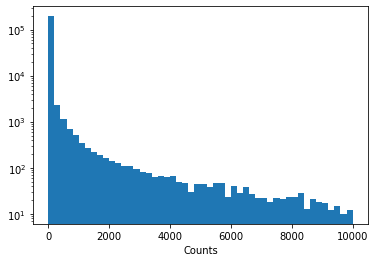

In [14]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
# tokens = <YOUR CODE HERE>
tokens = np.array(list(token_counts.keys()))[np.array(list(token_counts.values()))>=min_count].tolist()

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [17]:
# token_to_id = <your code here>
token_to_id={tokens[i]:i for i in range (len(tokens))}

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [19]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [23]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [24]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[1194,  395,  916,  132,  287,  388,   74,   74, 1349, 7800],
        [1586,   94, 1614, 2175,   86, 2175, 1527,   74, 1439,   15],
        [  74,  340, 1569,   94, 1171,  409,  168,   74,    0, 1827]],
       dtype=int32),
 'Log1pSalary': array([ 9.852247, 10.434145,  9.741028], dtype=float32),
 'Title': array([[1194,  395,  916,  132,  287,  388,    1,    1,    1,    1],
        [1586,   94,   33,  374, 3781,  142, 5622, 6444,    1,    1],
        [  74,  340, 1569,   94, 1171,  409,  168,   74,   82,   74]],
       dtype=int32)}

### Finally, let's talk deep learning

Our model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [113]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

class SoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim=dim

    def forward(self, x):
        x=x*torch.softmax(x, dim=1)
        return x.sum(dim=self.dim)

In [116]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1, bias=False)
        self.pool1 = GlobalMaxPooling()
        self.softpool1=SoftmaxPooling()
        self.dense1 = nn.LazyLinear(out_size)
        self.dense2=nn.LazyLinear(out_size)
        self.batch1=nn.BatchNorm1d (out_size)
        self.batch2=nn.BatchNorm1d (192)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        # print (h.shape)
        h1=self.conv1 (h)
        h1=self.batch1(h1)
        # print (h1.shape)

        h2=self.conv1 (h)
        h2=self.batch1(h2)

        h3=self.conv1 (h)
        h3=self.batch1(h3)

        h=torch.cat((h1, h2, h3), dim=1)
        # print (h.shape)

        # h=self.pool1 (h)
        # h=self.batch2(h)
        h=self.softpool1(h)
        h=self.batch2(h)
        
        # print (h.shape)

        h=self.dense1(h)
        # print (h.shape)
        h=nn.ReLU()(h)
        # print (h.shape)
        h=self.dense2(h)

        
        # return <YOUR CODE>
        return h

In [115]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

torch.Size([3, 192])
Seems fine


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


__Task 2.1__ Create description encoder

In [117]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
# <YOUR CODE HERE>
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1, bias=False)
        self.pool1 = GlobalMaxPooling()
        self.softpool1=SoftmaxPooling()
        self.dense1 = nn.LazyLinear(out_size)
        self.dense2=nn.LazyLinear(out_size)
        self.batch1=nn.BatchNorm1d (out_size)
        self.batch2=nn.BatchNorm1d (192)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        # print (h.shape)
        h1=self.conv1 (h)
        h1=self.batch1(h1)
        # print (h1.shape)

        h2=self.conv1 (h)
        h2=self.batch1(h2)

        h3=self.conv1 (h)
        h3=self.batch1(h3)

        h=torch.cat((h1, h2, h3), dim=1)
        # print (h.shape)

        # h=self.pool1 (h)
        # h=self.batch2(h)
        h=self.softpool1(h)
        h=self.batch2(h)
        
        # print (h.shape)

        h=self.dense1(h)
        # print (h.shape)
        h=nn.ReLU()(h)
        # print (h.shape)
        h=self.dense2(h)

        
        # return <YOUR CODE>
        return h

In [118]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


__ Task 2.2__ Build one network ~~to rule them all~~

In [119]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        # <YOUR CODE>
        self.cat_encoder=nn.Sequential (
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU (),
            nn.LazyLinear(64),
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        # <YOUR CODE>
        self.output=nn.Sequential (
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(n_cat_features),
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        # desc_h = <YOUR CODE>
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        # cat_h = <YOUR CODE>
        cat_h=self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        # <YOUR CODE>
        joint_h=self.output(joint_h)[:, 0]

        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        # return <YOUR CODE>
        return joint_h

In [120]:
dev=["cuda" if torch.cuda.is_available() else "cpu"][0]
print ("Cuda is available ", torch.cuda.is_available())
print ("Current device: ", dev)

Cuda is available  True
Current device:  cuda


In [121]:
model = FullNetwork().to(dev)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [122]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(dev)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(dev)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(dev)
reference = Variable(torch.FloatTensor(batch[target_column])).to(dev)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [123]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [124]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [125]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [126]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [137]:
model = FullNetwork().to(dev)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

from IPython.display import clear_output
train_LOSS=[]
train_MAE=[]
val_LOSS=[]
val_MAE=[]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


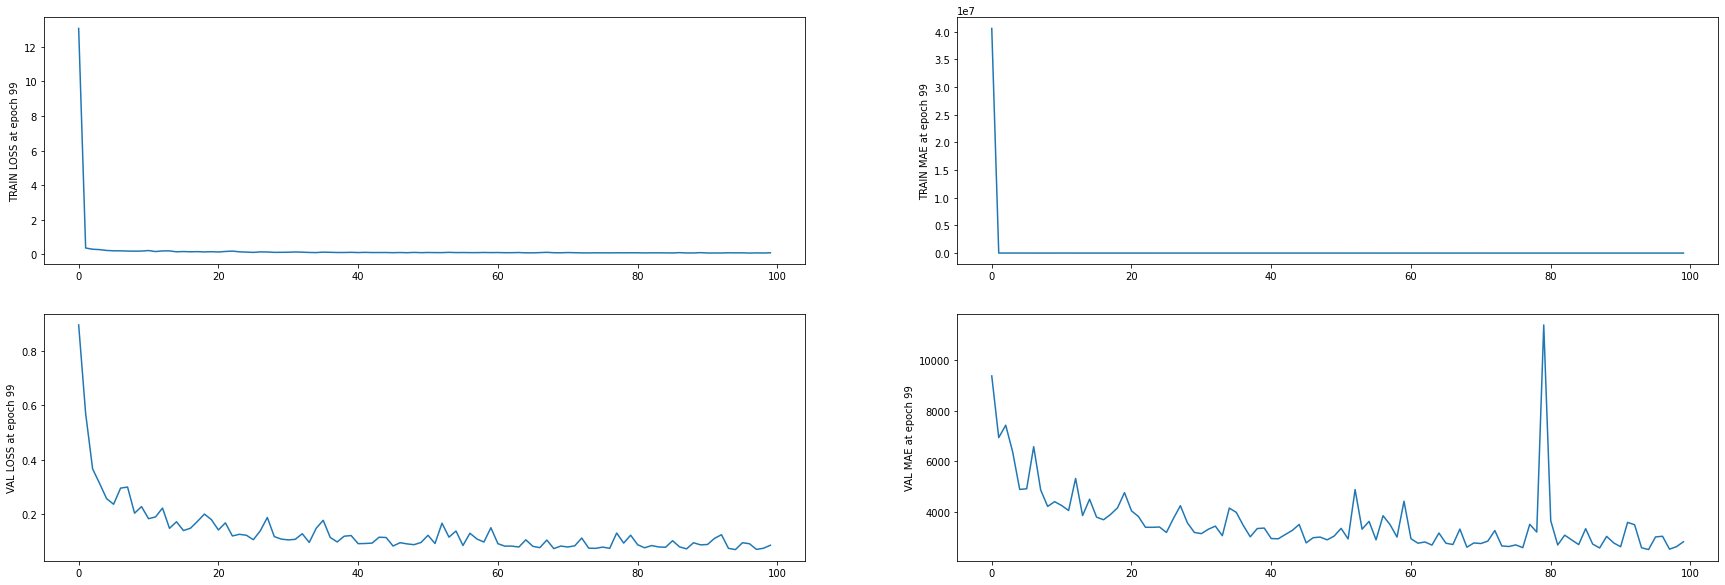


Currently:

	Train Loss:	0.08845
	Train MAE:	2948.12039
	Val Loss:	0.08597
	Val MAE:	2826.40120





In [138]:
for epoch_i in range(num_epochs):
    
    # print(f"Training at epoch {epoch_i}:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(dev)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(dev)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(dev)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(dev)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1
    
    train_LOSS.append(train_loss/train_batches)
    train_MAE.append(train_mae/train_batches)

    
    print(f"Validation at epoch {epoch_i}:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(dev)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(dev)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(dev)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(dev)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1


    val_LOSS.append(val_loss/val_batches)
    val_MAE.append(val_mae/val_batches)
    if min(val_MAE)==(val_mae/val_batches):
      torch.save(model.state_dict(), "model.ckpt")
    

    clear_output(True)
    y=np.arange (len(train_LOSS))
    plt.figure (figsize=(30, 10))
    plt.title (f"Epoch {epoch_i}")

    colors=['b']*len(train_LOSS)
    colors[-1]='r'
    plt.subplot (221)
    plt.plot(y, np.array(train_LOSS))
    plt.ylabel (f"TRAIN LOSS at epoch {epoch_i}")
    
    plt.subplot(222)
    plt.plot (y, np.array(train_MAE))
    plt.ylabel (f"TRAIN MAE at epoch {epoch_i}")
    
    plt.subplot(223)
    plt.plot (y, np.array(val_LOSS))
    plt.ylabel (f"VAL LOSS at epoch {epoch_i}")
    
    plt.subplot(224)
    plt.plot (y, np.array(val_MAE))
    plt.ylabel (f"VAL MAE at epoch {epoch_i}")

    plt.show()

    print("\nCurrently:\n")
    print("\tTrain Loss:\t%.5f" % (train_loss / train_batches))
    print("\tTrain MAE:\t%.5f" % (train_mae / train_batches))
    print("\tVal Loss:\t%.5f" % (val_loss / val_batches))
    print("\tVal MAE:\t%.5f" % (val_mae / val_batches))
    print("\n\n")

In [140]:
model.load_state_dict(torch.load ("model.ckpt"))
model.eval()

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(34158, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (pool1): GlobalMaxPooling()
    (softpool1): SoftmaxPooling()
    (dense1): Linear(in_features=192, out_features=64, bias=True)
    (dense2): Linear(in_features=64, out_features=64, bias=True)
    (batch1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch2): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (desc_encoder): DescriptionEncoder(
    (emb): Embedding(34158, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (pool1): GlobalMaxPooling()
    (softpool1): SoftmaxPooling()
    (dense1): Linear(in_features=192, out_features=64, bias=True)
    (dense2): Linear(in_features=64, out_features=64, bias=True)
    (batch1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=Tru

In [141]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(dev)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(dev)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(dev)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(dev)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07005
	MAE:	2515.64477





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

TitleEncoder and DescriptorEncoder are built idendical, containing 1 layer of 3 parallel convolutions, which are normalized and concatenated at the output of the layer. It is followed by sequence of softmax pooling, normalization, dense and relu layers.
Categorical encoder is alternation of dense and relu layers. The three encoders are concatentated at the output and fed to the alternating layers of dense and relu. The plot of MAE and loss for both training and validation dataset is provided at each iteration. Through the iterations the model that is holding the best validation MAE is saved. The final evaluation is done based on that model. However, the overall trend of validation MAE as a function of iterations is respected in the sense that the best model MAE is close to the overall trend, that is, the best model is not a random downward spike.
Having mentioned spikes, the model iterations are accompanied by high amount of spikes, with, nonetheless, general decreasing trend of MAE. Through trials of different models, unfortunately, the amount of spikes could not be reduced.
It was also tried to download Google's pretrained word2vector data. However, it was too large together with the our dataset that colab notebook crashed due to overflow of RAM. Moreover, Google data required preprocessing, since our dataset contain some numbers, names of places in lower letter cases that are not present in it. So, as a result trial of  pretrained data is abandoned.
Recurrent option was not addressed at all, because of lack of experience in it.
Overall, model showed 2515 MAE and 0.07 loss in validation dataset at its best case. However, considering fluctuations, it can be said that model resulted MAE between 2500 and 3000 in average.
It should also be mentioned that it is not physically possible to try out several types of model architecture due to limitations in time (training takes considerable time) and also limitations over Google Colab's GPU allocations. Long time of running GPU computations results in disconnection and restriction in utilizing GPU for further coputations. That is why, for example, the better combination of pooling layers and parallel convolutions layers could not be investigated at the desired depth. It is also worth to argue that using different servers and different accounts to avoid the GPU restrictions is not a solid solution.

P.S. Data is downloaded directly by kaggle via API authenticator.
